# Enhancing Airline Service Through Automated Sentiment Analysis of Customer Reviews



**Motivation**



## Singapore Airlines Customer Reviews Dataset Information

The [Singapore Airlines Customer Reviews Dataset](https://www.kaggle.com/datasets/kanchana1990/singapore-airlines-reviews) aggregates 10,000 anonymized customer reviews, providing a broad perspective on the passenger experience with Singapore Airlines. 

The dimensions are shown below:
- **`published_date`**: Date and time of review publication.
- **`published_platform`**: Platform where the review was posted.
- **`rating`**: Customer satisfaction rating, from 1 (lowest) to 5 (highest).
- **`type`**: Specifies the content as a review.
- **`text`**: Detailed customer feedback.
- **`title`**: Summary of the review.
- **`helpful_votes`**: Number of users finding the review helpful.

## Importing Libraries

Please uncomment the code box below to pip install relevant dependencies for this notebook.

In [1]:
# !pip3 install -r requirements.txt

In [2]:
# Import necessary libraries

# Data manipulation
import pandas as pd
import numpy as np

# Statistical functions
from scipy.stats import zscore

# For concurrency (running functions in parallel)
from concurrent.futures import ThreadPoolExecutor

# For caching (to speed up repeated function calls)
from functools import lru_cache

# For progress tracking
from tqdm import tqdm

# Plotting and Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Language Detection packages
# `langdetect` for detecting language
from langdetect import detect as langdetect_detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# `langid` for an alternative language detection method
from langid import classify as langid_classify

# Text Preprocessing and NLP
# Stopwords (common words to ignore) from NLTK
from nltk.corpus import stopwords
# Tokenizing sentences/words
from nltk.tokenize import word_tokenize
# Lemmatization (converting words to their base form)
from nltk.stem import WordNetLemmatizer
import nltk
# Regular expressions for text pattern matching
import re

# Word Cloud generation
from wordcloud import WordCloud

# For generating n-grams
from nltk.util import ngrams
from collections import Counter

## Data Preparation (Loading CSV)

Load the `singapore_airline_reviews.csv` file into a pandas DataFrame `data`.

In [3]:
data = pd.read_csv("singapore_airlines_reviews.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   published_date      10000 non-null  object
 1   published_platform  10000 non-null  object
 2   rating              10000 non-null  int64 
 3   type                10000 non-null  object
 4   text                10000 non-null  object
 5   title               9999 non-null   object
 6   helpful_votes       10000 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 547.0+ KB


In [4]:
data.head()

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0


# Data Cleaning

## Remove Duplicate Rows

- Drop duplicate rows from the dataframe (`data`) and reset the index.

In [5]:
data = data.drop_duplicates().reset_index(drop=True)

# Display the new dataframe shape
print("The new shape is: ", data.shape)

# Make sure no more duplicates are present
print("Remaining duplicate rows:", data.duplicated().sum())

The new shape is:  (10000, 7)
Remaining duplicate rows: 0


## Check for Null Values

- Here we check which features have null values using the `isnull()` function.

In [6]:
# In this case only `title` feature has one null value, will fill it with empty string " "
data.isnull().sum()

published_date        0
published_platform    0
rating                0
type                  0
text                  0
title                 1
helpful_votes         0
dtype: int64

In [7]:
# Fill missing values with empty string
data = data.fillna("")

In [8]:
# Verify that there are no missing values
data.isnull().sum()

published_date        0
published_platform    0
rating                0
type                  0
text                  0
title                 0
helpful_votes         0
dtype: int64

## Convert data types

Since the column `published_date` is in data type (`str`), we will
- Convert `published_date` to a standard timezone (UTC) format as a new column `date`.
- Drop the original `published_date` column after conversion and reset the index.

In [9]:
# Set `utc=True` to convert the date to common timezone (UTC)
data["date"] = pd.to_datetime(data["published_date"], utc=True)
print(data["date"].dtype)

datetime64[ns, UTC]


In [10]:
# Drop `published_date` column and reset the index
data = data.drop(columns=["published_date"]).reset_index(drop=True)
data.head()

,published_platform,rating,type,text,title,helpful_votes,date
0,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,2024-03-12 18:41:14+00:00
1,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0,2024-03-11 23:39:13+00:00
2,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,2024-03-11 16:20:23+00:00
3,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,2024-03-11 11:12:27+00:00
4,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,2024-03-10 09:34:18+00:00


## Remove Outliers

### `text`

The `text` column of `data`, which is of string (`str`) type, may contain values with unusually long lengths, indicating the presence of outliers. We will identify the outliers using [Z-score method].

1. Create a new column `text_length` in the DataFrame `data` by calculating the length of each review. (Set the value as 0 if the correponding `text` column has NaN values.)

2. Check the statistics of `text_length` using `describe()` method.

3. Calculate the mean and standard deviation of the `text_length` column.

4. Set the Z-score threshold for identifying outliers to 3.

5. Identify outliers of the `text_length` column and set the corresponding `text` to np.nan.

6. Drop the `text_length` column from the DataFrame.

In [11]:
data['text_length'] = data['text'].apply(lambda x: len(x) if pd.notna(x) else 0)
print(data.head(3))

TL = data["text_length"]
stats_TL = TL.describe()
print(stats_TL)

  published_platform  rating    type  \
0            Desktop       3  review   
1            Desktop       5  review   
2            Desktop       1  review   

                                                text  \
0  We used this airline to go from Singapore to L...   
1  The service on Singapore Airlines Suites Class...   
2  Booked, paid and received email confirmation f...   

                                               title  helpful_votes  \
0                                                 Ok              0   
1  The service in Suites Class makes one feel lik...              0   
2                         Don’t give them your money              0   

                       date  text_length  
0 2024-03-12 18:41:14+00:00         1352  
1 2024-03-11 23:39:13+00:00         4666  
2 2024-03-11 16:20:23+00:00          420  
count    10000.000000
mean       556.526800
std        640.290638
min        100.000000
25%        228.000000
50%        380.000000
75%        665.000000
max

In [12]:
mean_TL = TL.mean()
# print(mean_TL)

sd_TL = TL.std()
# print(sd_TL)

threshold = 3

z_score = zscore(TL)
# print(z_score)

# Remove 'text' of lengths that are greater than 3 standard deviations above the mean
data.loc[abs(z_score) > threshold, 'text'] = np.nan
# print(data.head(3))

data = data.drop("text_length", axis=1)

data.head()
data.shape

(10000, 7)

### `title`

Similarly, the `title` column of `data` (of type `str`) may also contain values with unusually long lengths, indicating the presence of outliers.

1. Create a new column `title_length` in the DataFrame `data` by calculating the length of each price value. (Set the value as 0 if the correponding `title` column has NaN values.)

2. Check the statistics of `title_length` using `describe()` method and display its unique values.

3. Identify the outlier values by inspecting the content in `title` corresponding to the abnormal value in `title_length` and set the corresponding value of `title` to np.nan.

4. Drop the `title_length` column from the DataFrame.

In [13]:
data['title_length'] = data['title'].apply(lambda x: len(x) if pd.notna(x) else 0)
print(data.head(3))

TL = data["title_length"]
stats_TL = TL.describe()
print(stats_TL)

  published_platform  rating    type  \
0            Desktop       3  review   
1            Desktop       5  review   
2            Desktop       1  review   

                                                text  \
0  We used this airline to go from Singapore to L...   
1                                                NaN   
2  Booked, paid and received email confirmation f...   

                                               title  helpful_votes  \
0                                                 Ok              0   
1  The service in Suites Class makes one feel lik...              0   
2                         Don’t give them your money              0   

                       date  title_length  
0 2024-03-12 18:41:14+00:00             2  
1 2024-03-11 23:39:13+00:00            51  
2 2024-03-11 16:20:23+00:00            26  
count    10000.000000
mean        28.409500
std         17.279742
min          0.000000
25%         16.000000
50%         24.000000
75%         36.000000

In [14]:
mean_TL = TL.mean()
# print(mean_TL)

sd_TL = TL.std()
# print(sd_TL)

threshold = 3

z_score = zscore(TL)
# print(z_score)

# Remove 'title' of lengths that are greater than 3 standard deviations above the mean
data.loc[abs(z_score) > threshold, 'title'] = np.nan
# print(data.head(3))

data = data.drop("title_length", axis=1)
data.head()

,published_platform,rating,type,text,title,helpful_votes,date
0,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0,2024-03-12 18:41:14+00:00
1,Desktop,5,review,NaN,The service in Suites Class makes one feel lik...,0,2024-03-11 23:39:13+00:00
2,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0,2024-03-11 16:20:23+00:00
3,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0,2024-03-11 11:12:27+00:00
4,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0,2024-03-10 09:34:18+00:00


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   published_platform  10000 non-null  object             
 1   rating              10000 non-null  int64              
 2   type                10000 non-null  object             
 3   text                9846 non-null   object             
 4   title               9834 non-null   object             
 5   helpful_votes       10000 non-null  int64              
 6   date                10000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 547.0+ KB


In [16]:
#check data types of each column, make sure they are correct
print(data.dtypes)

# Make sure no more duplicates are present
print("Remaining duplicate rows:", data.duplicated().sum())

# Check for outliers in ratings
print("Unique ratings:", data['rating'].unique())

published_platform                 object
rating                              int64
type                               object
text                               object
title                              object
helpful_votes                       int64
date                  datetime64[ns, UTC]
dtype: object
Remaining duplicate rows: 0
Unique ratings: [3 5 1 2 4]


In [17]:
data.isnull().sum()

published_platform      0
rating                  0
type                    0
text                  154
title                 166
helpful_votes           0
date                    0
dtype: int64

# Feature Engineering

### Create new column `full_review`
Since there are some rows with empty `text` and `title`, we will concatenate both columns (`text` and `title`) to form a new column `full_review`.
1. Replace `NaN` values in `text` and `title` with an empty string.

2. Combine `text` and `title` into `full_review`.

3. Strip any leading/trailing whitespaces in `full_review`.

4. Drop `text` and `title` columns.

In [18]:
# 1) Fill NaN values in 'text' and 'title' with an empty string
data['title'] = data['title'].fillna('')
data['text'] = data['text'].fillna('')

# 2) Combine 'text' and 'title' into 'full_review'
data['full_review'] = data['text'] + " " + data['title']

# 3) Strip any leading/trailing whitespace
data['full_review'] = data['full_review'].str.strip()

# 4) Drop `text` and `title` columns
data = data.drop(columns = ['text', 'title'])

# Check if the 'full_review' column was added and if 'text' and 'title' columns has been dropped
print(data.head())
print("\nThe old shape is:",data.shape)

  published_platform  rating    type  helpful_votes                      date  \
0            Desktop       3  review              0 2024-03-12 18:41:14+00:00   
1            Desktop       5  review              0 2024-03-11 23:39:13+00:00   
2            Desktop       1  review              0 2024-03-11 16:20:23+00:00   
3            Desktop       5  review              0 2024-03-11 11:12:27+00:00   
4            Desktop       2  review              0 2024-03-10 09:34:18+00:00   

                                         full_review  
0  We used this airline to go from Singapore to L...  
1  The service in Suites Class makes one feel lik...  
2  Booked, paid and received email confirmation f...  
3  Best airline in the world, seats, food, servic...  
4  Premium Economy Seating on Singapore Airlines ...  

The old shape is: (10000, 6)


### Remove empty strings
1. Drop rows where `full_review` are empty strings and reset the index.

2. Check if there are no more null values in `data`.

In [19]:
# 1) Drop rows where `full_review` are empty strings and reset the index
data = data[data['full_review'] != ""].reset_index(drop=True)
print("The new shape is:",data.shape)

# 2) Check if there are no more null values in `data`
data.isnull().sum()

The new shape is: (9989, 6)


published_platform    0
rating                0
type                  0
helpful_votes         0
date                  0
full_review           0
dtype: int64

### Create new column `language`
In the case where there are rows where `full_review` are in different languages (e.g., French, Russian, etc.) other than English. We decided to use 2 different language detector libraries (`langdetect`, `langid`) on the `full_review` column and combined the predictions of all 2 libraries and selecting the most frequent predicted language.

**Reason**: `langdetect` might perform well on longer texts while `langid` is more reliable on short texts, using multiple detectors reduces the likelihood of misclassification and mitigates individual detector errors, leading to more accurate overall predictions. Also, even if one detector fails or throws an error, the other can still provide predictions, therefore improving the robustness of the language detection.

1. Set a seed for `langdetect` to ensure reproducibility.

2. Preprocess the text in `full_review`:
    - a\) Function to remove non-alphabetic characters and normalise whitespaces in  `full_review`.
    - b\) Function to determine if the text is non-language (e.g., numbers, symbols only).

3. Two functions for language detection:
    - a\) Using `langdetect`.
    - b\) Using `langid`.

4. Function for calculating majority vote for each language.

5. Function for parallel processing for efficiency.

6. Caching function for repeated inputs

7. Function for choosing language based on combined majority voting.

8. Applying the combined function on `full_review` column.

9. Display the resulting `data` DataFrame.

### <span style="color:red">The code below will take approximately 1 minute to run!</span>

In [20]:
# 1) Set a seed for langdetect to ensure reproducibility
DetectorFactory.seed = 0

# 2a) Simplified preprocessing: only remove non-alphabetic characters
def preprocess_text_simple(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    return text.strip()

# 2b) Check if the text is non-language (e.g., numbers, symbols only)
def is_non_language_text(text):
    if re.match(r'^[^a-zA-Z]*$', text):  # Check if text has no alphabetic characters
        return True
    return False

# 3a) Function to get langdetect prediction
def get_langdetect_prediction(text):
    try:
        # Directly use text without preprocessing for efficiency
        if len(text) < 10 or is_non_language_text(text):
            return "unknown"
        lang = langdetect_detect(text)
        return lang
    except LangDetectException:
        return "unknown"

# 3b) Function to get langid prediction
def get_langid_prediction(text):
    try:
        lang, _ = langid_classify(text)
        if len(text) < 10 or is_non_language_text(text):
            return "unknown"
        return lang
    except Exception:
        return "unknown"

# 4) Function to calculate majority vote for each language
def calculate_majority_vote(predictions):
    vote_counts = {}
    for lang in predictions:
        if lang in vote_counts:
            vote_counts[lang] += 1
        else:
            vote_counts[lang] = 1
    return vote_counts

# 5) Parallel processing for efficiency with limited workers
def parallel_detection(text):
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(lambda func: func(text), 
                                    [get_langdetect_prediction, get_langid_prediction]))
    return results

# 6) Caching function for repeated inputs
@lru_cache(maxsize=500)
def get_cached_language(text):
    return combined_language_detection(text)

# 7) Combined majority voting language detection function
def combined_language_detection(text):
    # Check if the text is non-language (e.g., numbers, symbols only)
    if is_non_language_text(text):
        return "unknown"
    
    # Run the detectors in parallel for efficiency
    predictions = parallel_detection(text)
    
    # Calculate majority vote for each language based on predictions
    vote_counts = calculate_majority_vote(predictions)
    
    # Determine the language with the highest majority vote
    final_language = max(vote_counts, key=vote_counts.get)
    
    # If "unknown" is the most common or if all detectors fail, return "unknown"
    if final_language == "unknown" or vote_counts[final_language] <= 1:
        return "unknown"
    
    return final_language

# 8) Apply the cached function to each text in the DataFrame with a progress bar
data['language'] = [get_cached_language(text) for text in tqdm(data['full_review'], desc="Language Detection")]

# 9) Display the DataFrame with detected languages
data

Language Detection: 100%|██████████| 9989/9989 [01:26<00:00, 115.61it/s]


,published_platform,rating,type,helpful_votes,date,full_review,language
0,Desktop,3,review,0,2024-03-12 18:41:14+00:00,We used this airline to go from Singapore to L...,en
1,Desktop,5,review,0,2024-03-11 23:39:13+00:00,The service in Suites Class makes one feel lik...,en
2,Desktop,1,review,0,2024-03-11 16:20:23+00:00,"Booked, paid and received email confirmation f...",en
3,Desktop,5,review,0,2024-03-11 11:12:27+00:00,"Best airline in the world, seats, food, servic...",en
4,Desktop,2,review,0,2024-03-10 09:34:18+00:00,Premium Economy Seating on Singapore Airlines ...,en
...,...,...,...,...,...,...,...
9984,Desktop,5,review,1,2018-08-06 07:48:21+00:00,First part done with Singapore Airlines - acce...,en
9985,Mobile,5,review,1,2018-08-06 02:50:29+00:00,And again a great Flight with Singapore Air. G...,en
9986,Desktop,5,review,1,2018-08-06 02:47:06+00:00,"We flew business class from Frankfurt, via Sin...",en
9987,Desktop,4,review,2,2018-08-06 00:32:03+00:00,"As always, the A380 aircraft was spotlessly pr...",en


In [21]:
# See distribution of languages
data["language"].value_counts()

language
en         9952
unknown      32
es            1
de            1
th            1
fr            1
sv            1
Name: count, dtype: int64

In [22]:
# Drop rows where language is NOT in english and reset the index
data = data[data['language'] == 'en'].reset_index(drop=True)
print(data.shape)

(9952, 7)


We will drop the `language` column since all values of `language` are `en` and all `full_review` are in the English language.

In [23]:
data.info()
data.drop(columns=["language"], inplace=True)
print("The new shape is:", data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9952 entries, 0 to 9951
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   published_platform  9952 non-null   object             
 1   rating              9952 non-null   int64              
 2   type                9952 non-null   object             
 3   helpful_votes       9952 non-null   int64              
 4   date                9952 non-null   datetime64[ns, UTC]
 5   full_review         9952 non-null   object             
 6   language            9952 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 544.4+ KB
The new shape is: (9952, 6)


In [24]:
data.head()

,published_platform,rating,type,helpful_votes,date,full_review
0,Desktop,3,review,0,2024-03-12 18:41:14+00:00,We used this airline to go from Singapore to L...
1,Desktop,5,review,0,2024-03-11 23:39:13+00:00,The service in Suites Class makes one feel lik...
2,Desktop,1,review,0,2024-03-11 16:20:23+00:00,"Booked, paid and received email confirmation f..."
3,Desktop,5,review,0,2024-03-11 11:12:27+00:00,"Best airline in the world, seats, food, servic..."
4,Desktop,2,review,0,2024-03-10 09:34:18+00:00,Premium Economy Seating on Singapore Airlines ...


# Exploratory Data Analysis (EDA)

## Summary Statistics

In [25]:
# View describe statistics of numerical variables (`rating` and `helpful_votes`)
data.describe()

,rating,helpful_votes
count,9952.000000,9952.000000
mean,4.022106,1.270699
std,1.341616,2.723199
min,1.000000,0.000000
25%,3.000000,0.000000
50%,5.000000,1.000000
75%,5.000000,2.000000
max,5.000000,158.000000


## Distribution of Ratings

/var/folders/km/dcrhp08528qckw4f5mb5cg5r0000gn/T/ipykernel_69868/2251192400.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


rating
5    5413
4    1962
1    1039
3    1000
2     538
Name: count, dtype: int64


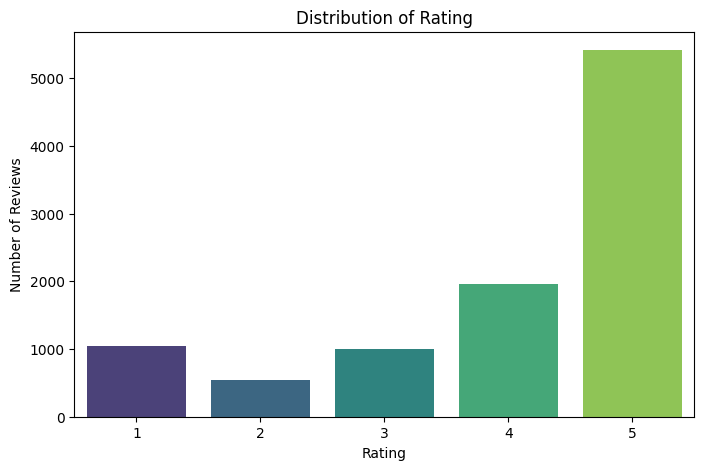

In [26]:
# Rating distribution
print(data['rating'].value_counts())

# Ensure that all ratings from 1 to 5 are represented
rating_counts = data['rating'].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)

# Create a bar chart using seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.show()

## Distribution of Review Length

Here, we create a column `review_length` that returns the length of the `full_review` for each row.

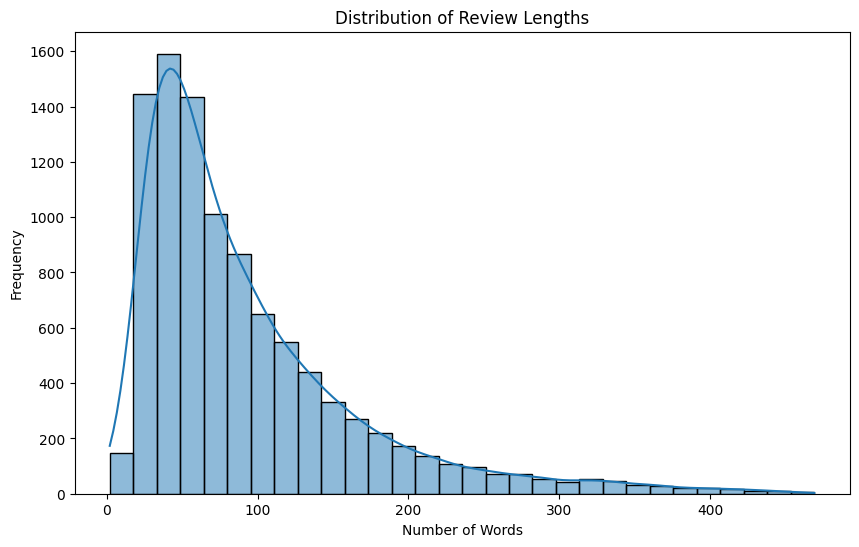

Review Length Statistics:
 count    9952.000000
mean       92.914992
std        73.973382
min         2.000000
25%        42.000000
50%        69.000000
75%       120.000000
max       469.000000
Name: review_length, dtype: float64


In [27]:
# Calculate review length in words
data['review_length'] = data['full_review'].apply(lambda x: len(x.split()))

# Plot distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['review_length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Print basic statistics for review length
print("Review Length Statistics:\n", data['review_length'].describe())

## Review Length vs. Rating Correlation

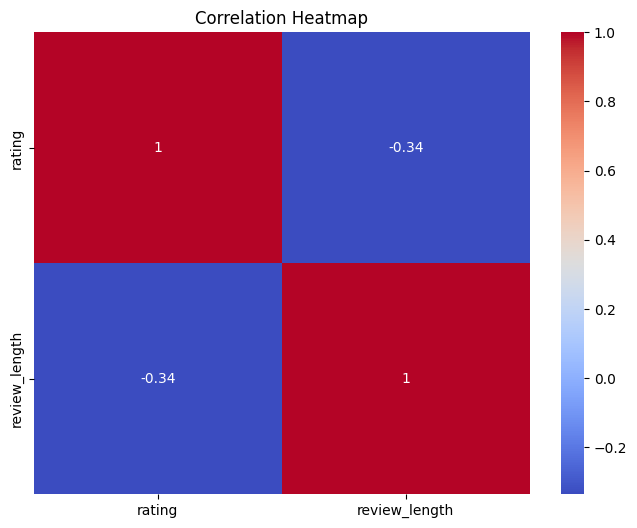

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(data[['rating', 'review_length']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Based on the heatmap, we can see that `review_length` is **negatively correlated** to `rating`, which means that as the length of review increases, the rating tends to decrease.

A possible explanation could be that a customer who leaves a 1-star or 2-star rating may write a longer, more detailed review, explaining their dissatisfaction or the problems they encountered. On the other hand, a customer who leaves a 5-star rating may write a short, positive review like "Great service!" or "Excellent!".

## Temporal Analysis, using the `date` column

In [29]:
print(data.dtypes)

published_platform                 object
rating                              int64
type                               object
helpful_votes                       int64
date                  datetime64[ns, UTC]
full_review                        object
review_length                       int64
dtype: object


### Number of Reviews per Year

/var/folders/km/dcrhp08528qckw4f5mb5cg5r0000gn/T/ipykernel_69868/2721722729.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['year_month'] = data['date'].dt.to_period('M')  # Year and month combined


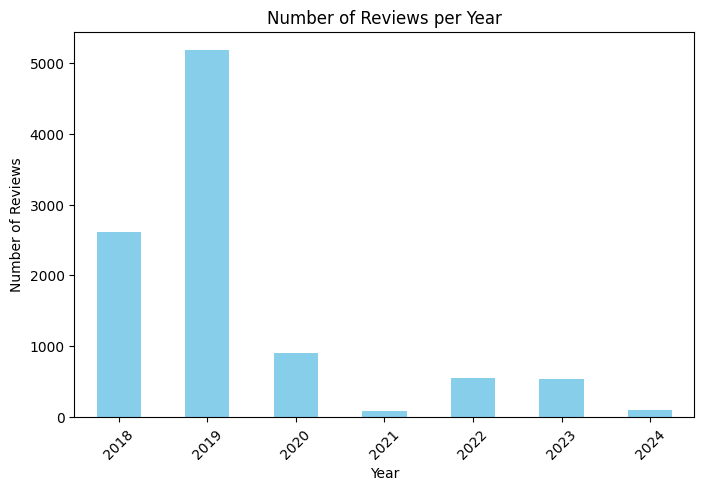

In [30]:
# Feature Engineering - creating day,week,month,year columns
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.day_name()  # Day name like 'Monday', 'Tuesday'
data['year_month'] = data['date'].dt.to_period('M')  # Year and month combined

## Yearly Review Trend
reviews_per_year = data.groupby('year').size()

# Plot the trend of reviews per year
plt.figure(figsize=(8, 5))
reviews_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

### Average Rating per Year

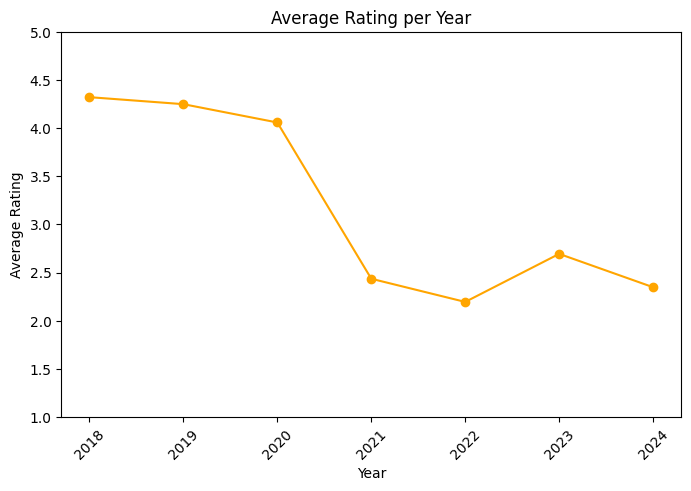

In [31]:
avg_rating_per_year = data.groupby('year')['rating'].mean()

# Plot the trend of average ratings per year
plt.figure(figsize=(8, 5))
avg_rating_per_year.plot(kind='line',marker='o', color='orange')
plt.title('Average Rating per Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.ylim(1, 5)  # Set y-axis limit to the rating range
plt.xticks(rotation=45)
plt.show()

### Average Rating per Month

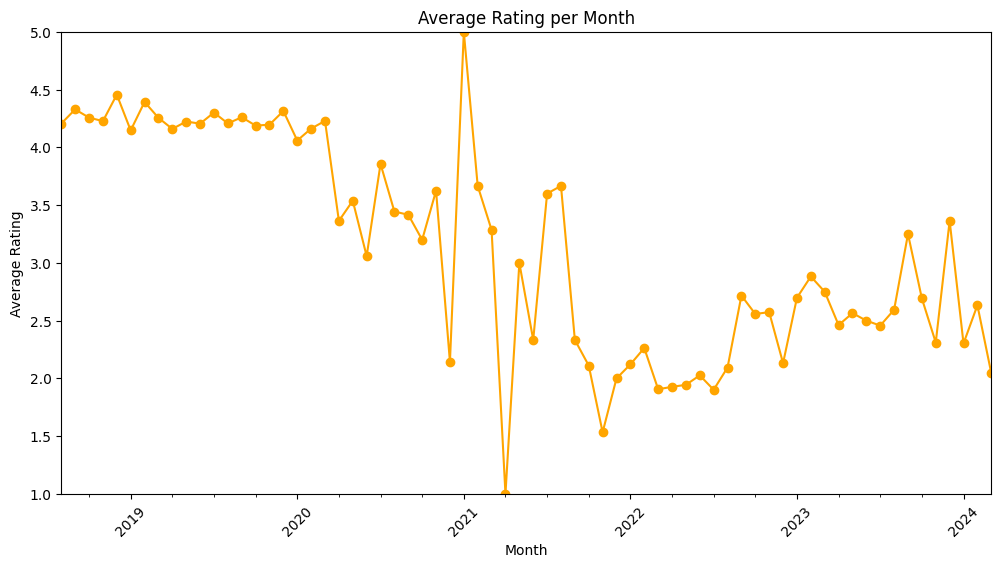

In [32]:
avg_rating_per_month = data.groupby('year_month')['rating'].mean()

# Plot the trend of average ratings over time
plt.figure(figsize=(12, 6))
avg_rating_per_month.plot(kind='line', marker='o', color='orange')
plt.title('Average Rating per Month')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.ylim(1, 5)  # Set y-axis limit to the rating range
plt.xticks(rotation=45)
plt.show()

### Number of reviews by month

/var/folders/km/dcrhp08528qckw4f5mb5cg5r0000gn/T/ipykernel_69868/3439443353.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reviews_by_month.index, y=reviews_by_month.values, palette='viridis')


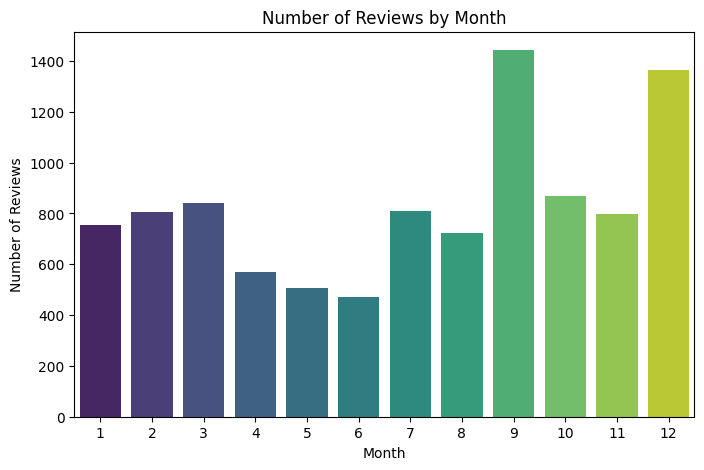

In [33]:
# Number of reviews by month
reviews_by_month = data['month'].value_counts().sort_index()

# Plot reviews by month
plt.figure(figsize=(8, 5))
sns.barplot(x=reviews_by_month.index, y=reviews_by_month.values, palette='viridis')
plt.title('Number of Reviews by Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

### Number of reviews by day of week

/var/folders/km/dcrhp08528qckw4f5mb5cg5r0000gn/T/ipykernel_69868/2613726791.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reviews_by_day.index, y=reviews_by_day.values, palette='viridis')


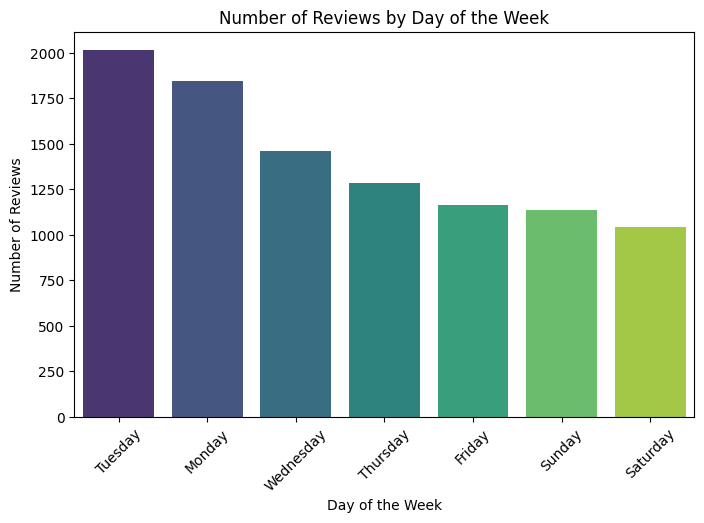

In [34]:
# Number of reviews by day of the week
reviews_by_day = data['day_of_week'].value_counts()

# Plot reviews by day of the week
plt.figure(figsize=(8, 5))
sns.barplot(x=reviews_by_day.index, y=reviews_by_day.values, palette='viridis')
plt.title('Number of Reviews by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

## Word Cloud (without text preprocessing)

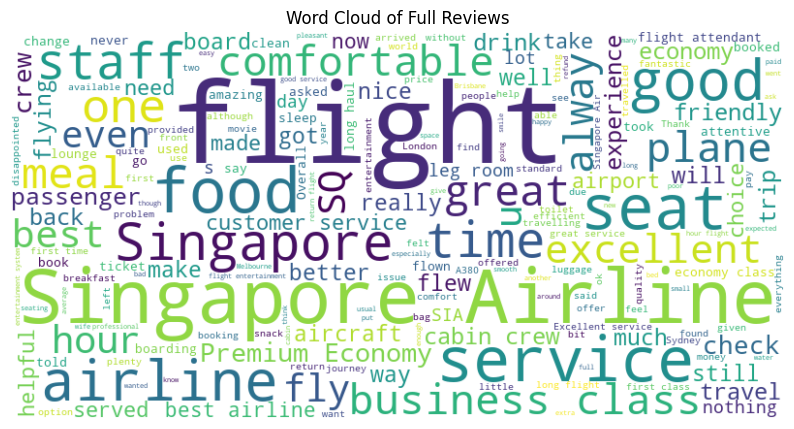

In [35]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['full_review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Full Reviews')
plt.show()

In [36]:
data.head()

,published_platform,rating,type,helpful_votes,date,full_review,review_length,year,month,day,day_of_week,year_month
0,Desktop,3,review,0,2024-03-12 18:41:14+00:00,We used this airline to go from Singapore to L...,252,2024,3,12,Tuesday,2024-03
1,Desktop,5,review,0,2024-03-11 23:39:13+00:00,The service in Suites Class makes one feel lik...,10,2024,3,11,Monday,2024-03
2,Desktop,1,review,0,2024-03-11 16:20:23+00:00,"Booked, paid and received email confirmation f...",83,2024,3,11,Monday,2024-03
3,Desktop,5,review,0,2024-03-11 11:12:27+00:00,"Best airline in the world, seats, food, servic...",28,2024,3,11,Monday,2024-03
4,Desktop,2,review,0,2024-03-10 09:34:18+00:00,Premium Economy Seating on Singapore Airlines ...,113,2024,3,10,Sunday,2024-03


# Text Preprocessing for NLP

Here we will define a function `process_full_review` that takes a textual value as input and applies the following processing steps in sequence:

1. Convert the input text to lowercase using the `lower()` function.

2. Tokenize the lowercase text using the `word_tokenize` function from the NLTK library.

3. Create a list (`alphabetic_tokens`) containing only alphanetic tokens using a list comprehension with a regular expression match.

4. Remove stopwords
-   Obtain a set of English stopwords using the `stopwords.words('english')` method.
-   Define a list of `allowed_words` that should not be removed.
-   Remove the stopwords (excluding those that should not be removed).

5. Apply lemmatization to each token in the list (`lemmatized_words`) using the `lemmatize` method.

6. Join the lemmatized tokens into a single processed text using the `join` method and return the processed text.

Create a new column `processed_full_review` in `data` by applying the `process_full_review` function to the `full_review` column.

In [37]:
# Ensure require NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [38]:
# Define function to process text
def process_full_review(text):
    processed_text = ""

    # Convert text to lowercase
    text = text.lower()

    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Keep only alphabetic tokens
    alphabetic_tokens = [i for i in tokens if re.match('^[a-zA-Z]+$', i)]

    if len(alphabetic_tokens) == 0:
        # Return empty processed text if there are no alphabetic tokens
        return processed_text

    # List of stopwords
    stop_words = stopwords.words('english')

    # List of allowed words (to preserve certain negative words and conjuctions)
    allowed_words = ["no", "not", "don't", "dont", "don", "but", 
                     "however", "never", "wasn't", "wasnt", "shouldn't",
                     "shouldnt", "mustn't", "musnt"]
    '''
    these words may carry important information, such as negative connotations. in examples such as
    "don't ever get this dish" -> if don't was removed, it may be interpreted as "get dish", which is of the opposite sentiment
    of what the original review is supposed to be.
    Conjunctions like "but" and "however" shows a contrast to the sentence said before, meaning that the sentiment can be
    negatively affected or at the very least, impacted. Similarly for "mustn't" or "shouldn't", they typically carry a negative sentiment.
    '''

    # Filter out stopwords, keeping allowed words
    filtered_tokens = [i for i in alphabetic_tokens if i not in stop_words or i in allowed_words]

    # Initialise the WordNet Lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Lemmatize the filtered tokens
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Join the lemmatized words back into a single string
    processed_text = ' '.join(lemmatized_words)

    return processed_text

In [39]:
# Enable tqdm for pandas (progress bar)
tqdm.pandas(desc="Processing Reviews")

# Apply process_full_review function with tqdm progress bar and expand the results into a separate column.
data['processed_full_review'] = data['full_review'].progress_apply(process_full_review)

data

Processing Reviews: 100%|██████████| 9952/9952 [00:06<00:00, 1603.52it/s]


,published_platform,rating,type,helpful_votes,date,full_review,review_length,year,month,day,day_of_week,year_month,processed_full_review
0,Desktop,3,review,0,2024-03-12 18:41:14+00:00,We used this airline to go from Singapore to L...,252,2024,3,12,Tuesday,2024-03,used airline go singapore london heathrow issu...
1,Desktop,5,review,0,2024-03-11 23:39:13+00:00,The service in Suites Class makes one feel lik...,10,2024,3,11,Monday,2024-03,service suite class make one feel like vip
2,Desktop,1,review,0,2024-03-11 16:20:23+00:00,"Booked, paid and received email confirmation f...",83,2024,3,11,Monday,2024-03,booked paid received email confirmation extra ...
3,Desktop,5,review,0,2024-03-11 11:12:27+00:00,"Best airline in the world, seats, food, servic...",28,2024,3,11,Monday,2024-03,best airline world seat food service brilliant...
4,Desktop,2,review,0,2024-03-10 09:34:18+00:00,Premium Economy Seating on Singapore Airlines ...,113,2024,3,10,Sunday,2024-03,premium economy seating singapore airline narr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9947,Desktop,5,review,1,2018-08-06 07:48:21+00:00,First part done with Singapore Airlines - acce...,35,2018,8,6,Monday,2018-08,first part done singapore airline acceptable c...
9948,Mobile,5,review,1,2018-08-06 02:50:29+00:00,And again a great Flight with Singapore Air. G...,26,2018,8,6,Monday,2018-08,great flight singapore air great unique servic...
9949,Desktop,5,review,1,2018-08-06 02:47:06+00:00,"We flew business class from Frankfurt, via Sin...",60,2018,8,6,Monday,2018-08,flew business class frankfurt via singapore br...
9950,Desktop,4,review,2,2018-08-06 00:32:03+00:00,"As always, the A380 aircraft was spotlessly pr...",80,2018,8,6,Monday,2018-08,always aircraft spotlessly presented boarding ...


### Using bigrams and trigrams 
- to see which words are commonly used together in the reviews

/var/folders/km/dcrhp08528qckw4f5mb5cg5r0000gn/T/ipykernel_69868/4136396747.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')


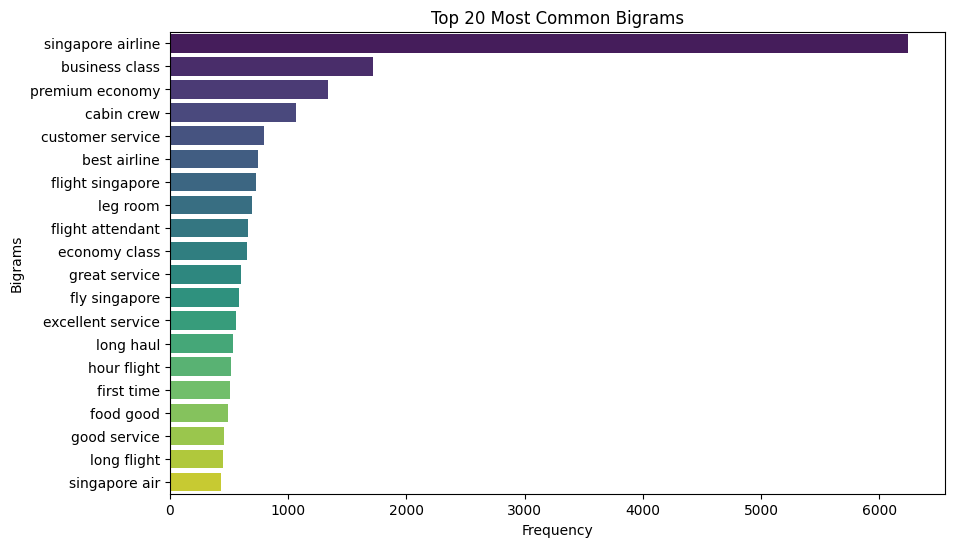

In [40]:
# Function to generate n-grams
def generate_ngrams(text, n=2):
    words = text.split()
    n_grams = ngrams(words, n)
    return [' '.join(grams) for grams in n_grams]

# Apply the function to the 'processed_full_review' column for bigrams
data['bigrams'] = data['processed_full_review'].apply(lambda x: generate_ngrams(x, n=2))

# Flatten list of all bigrams
all_bigrams = [bigram for sublist in data['bigrams'] for bigram in sublist]

# Get the 20 most common bigrams
bigram_freq = Counter(all_bigrams).most_common(20)

# Convert to DataFrame for visualization
bigram_df = pd.DataFrame(bigram_freq, columns=['Bigram', 'Frequency'])

# Plot the most common bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=bigram_df, palette='viridis')
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

/var/folders/km/dcrhp08528qckw4f5mb5cg5r0000gn/T/ipykernel_69868/3555589134.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Trigram', data=trigram_df, palette='magma')


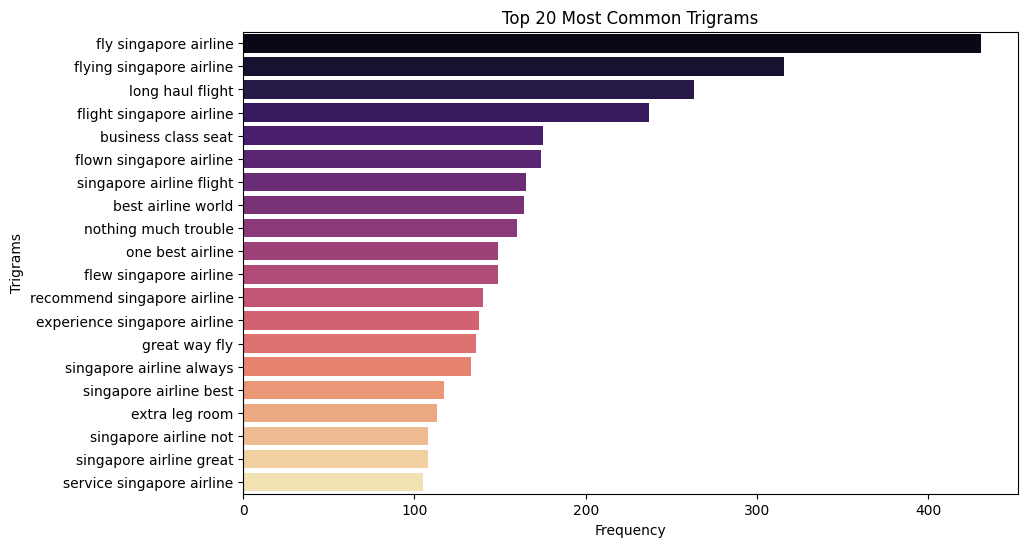

In [41]:
# Apply the function to the 'processed_full_review' column for trigrams
data['trigrams'] = data['processed_full_review'].apply(lambda x: generate_ngrams(x, n=3))

# Flatten list of all trigrams
all_trigrams = [trigram for sublist in data['trigrams'] for trigram in sublist]

# Get the 20 most common trigrams
trigram_freq = Counter(all_trigrams).most_common(20)

# Convert to DataFrame for visualization
trigram_df = pd.DataFrame(trigram_freq, columns=['Trigram', 'Frequency'])

# Plot the most common trigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Trigram', data=trigram_df, palette='magma')
plt.title('Top 20 Most Common Trigrams')
plt.xlabel('Frequency')
plt.ylabel('Trigrams')
plt.show()

### Word cloud after text processing

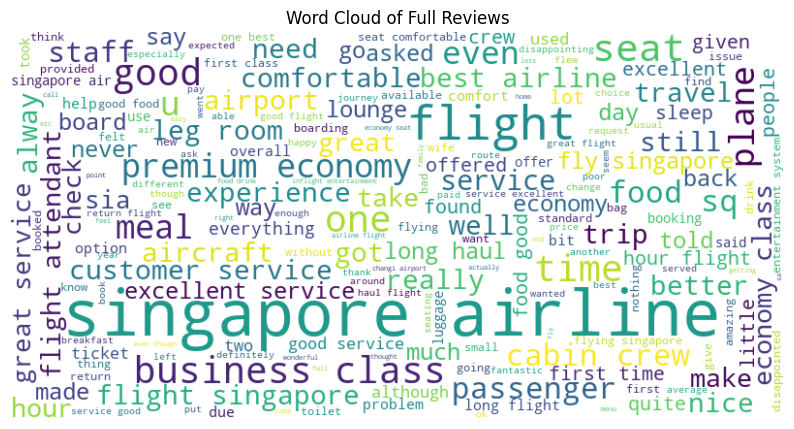

In [42]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['processed_full_review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Full Reviews')
plt.show()

## Advanced EDA (for sentiment analysis)

### Mapping ratings to sentiment labels

In [43]:
# Function to map ratings to sentiment
def rating_to_sentiment(rating):
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

# Apply the function to the 'rating' column
data['sentiment'] = data['rating'].apply(rating_to_sentiment)

# Check the sentiment distribution
print(data['sentiment'].value_counts())

sentiment
Positive    7375
Negative    1577
Neutral     1000
Name: count, dtype: int64


### Sentiment distribution analysis

/var/folders/km/dcrhp08528qckw4f5mb5cg5r0000gn/T/ipykernel_69868/473666683.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='viridis')


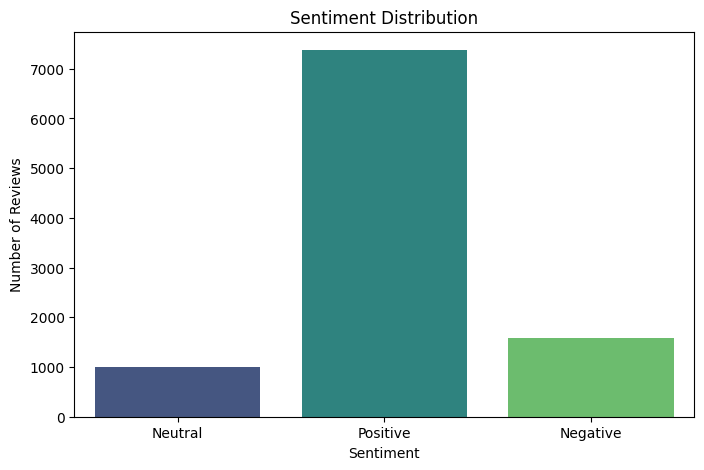

In [44]:
# Plot sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=data, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

### Sentiment trends over time

In [45]:
data['year'].value_counts()

year
2019    5183
2018    2613
2020     902
2022     545
2023     529
2024      95
2021      85
Name: count, dtype: int64

sentiment   Negative    Neutral   Positive
year                                      
2018        7.692308   8.840413  83.467279
2019        9.357515  10.534440  80.108046
2020       15.742794   8.536585  75.720621
2021       62.352941   3.529412  34.117647
2022       65.688073  11.559633  22.752294
2023       52.741021  12.854442  34.404537
2024       62.105263  12.631579  25.263158


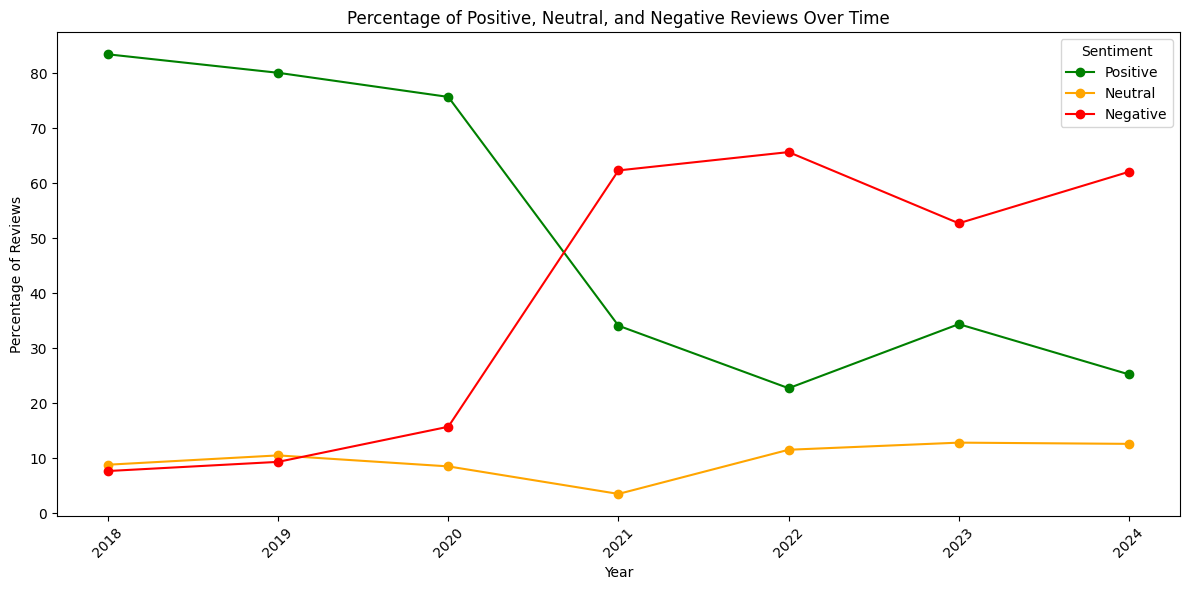

In [58]:
# Count the total number of reviews for each sentiment by year
sentiment_counts = data.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

# Calculate the percentage of each sentiment per month
sentiment_percentage = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100


print(sentiment_percentage)


# Convert PeriodIndex to string
sentiment_percentage.index = sentiment_percentage.index.astype(str)

# Plot all three sentiment lines on one axis
plt.figure(figsize=(12, 6))

# Plot Positive sentiment
plt.plot(sentiment_percentage.index, sentiment_percentage['Positive'], color='green', marker='o', label='Positive')

# Plot Neutral sentiment
plt.plot(sentiment_percentage.index, sentiment_percentage['Neutral'], color='orange', marker='o', label='Neutral')

# Plot Negative sentiment
plt.plot(sentiment_percentage.index, sentiment_percentage['Negative'], color='red', marker='o', label='Negative')

# Add labels and title
plt.title('Percentage of Positive, Neutral, and Negative Reviews Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage of Reviews')
plt.xticks(rotation=45)

# Add a legend to distinguish between the lines
plt.legend(title='Sentiment')

# Display the plot
plt.tight_layout()
plt.show()

### Top N-grams by sentiment

#### Positive reviews

In [96]:
# Function to generate n-grams
def generate_ngrams(text, n=2):
    words = text.split()
    n_grams = ngrams(words, n)
    return [' '.join(grams) for grams in n_grams]

# Generate bigrams for each sentiment
def ngram_by_sentiment(data, sentiment_label, n=2):
    filtered_data = data[data['sentiment'] == sentiment_label]
    ngrams_list = [ngram for sublist in filtered_data['processed_full_review'].apply(lambda x: generate_ngrams(x, n)) for ngram in sublist]
    ngram_freq = Counter(ngrams_list).most_common(10)
    return pd.DataFrame(ngram_freq, columns=[f'{n}-gram', 'Frequency'])

              2-gram  Frequency
0  singapore airline       4187
1     business class       1141
2         cabin crew        875
3    premium economy        732
4       best airline        649
5      great service        563
6  excellent service        544
7           leg room        531
8   flight singapore        495
9   flight attendant        486


/var/folders/km/dcrhp08528qckw4f5mb5cg5r0000gn/T/ipykernel_46605/3359693401.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='2-gram', data=positive_bigrams, palette='magma')


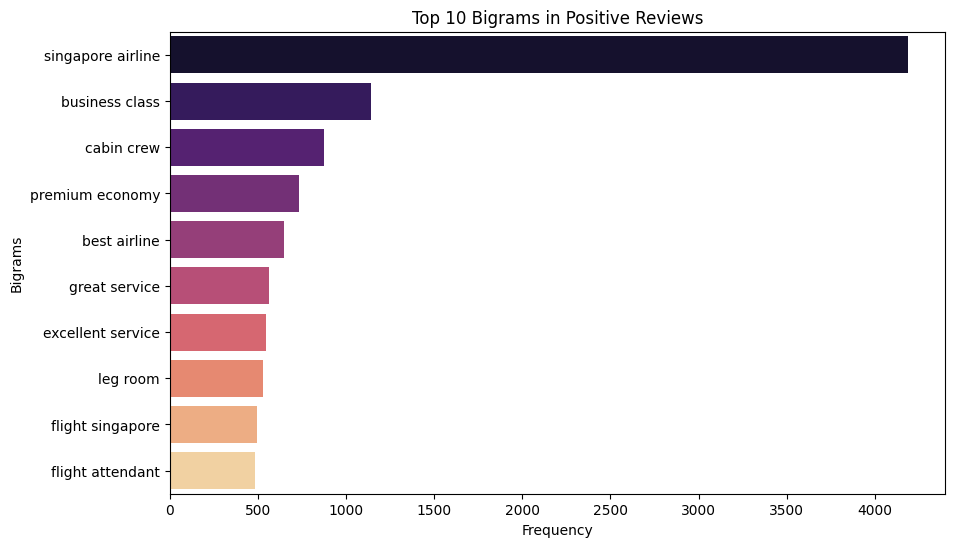

In [97]:
# Get top 10 bigrams for positive reviews
positive_bigrams = ngram_by_sentiment(data, 'Positive', n=2)
print(positive_bigrams)

# Plot bigrams in positive reviews
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='2-gram', data=positive_bigrams, palette='magma')
plt.title('Top 10 Bigrams in Positive Reviews')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

#### Negative reviews

              2-gram  Frequency
0  singapore airline       1468
1   customer service        472
2    premium economy        341
3     business class        334
4   flight singapore        144
5      singapore air        134
6        hour flight        118
7          could not        108
8      fly singapore        106
9      return flight        102


/var/folders/km/dcrhp08528qckw4f5mb5cg5r0000gn/T/ipykernel_46605/2522186512.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='2-gram', data=negative_bigrams, palette='magma')


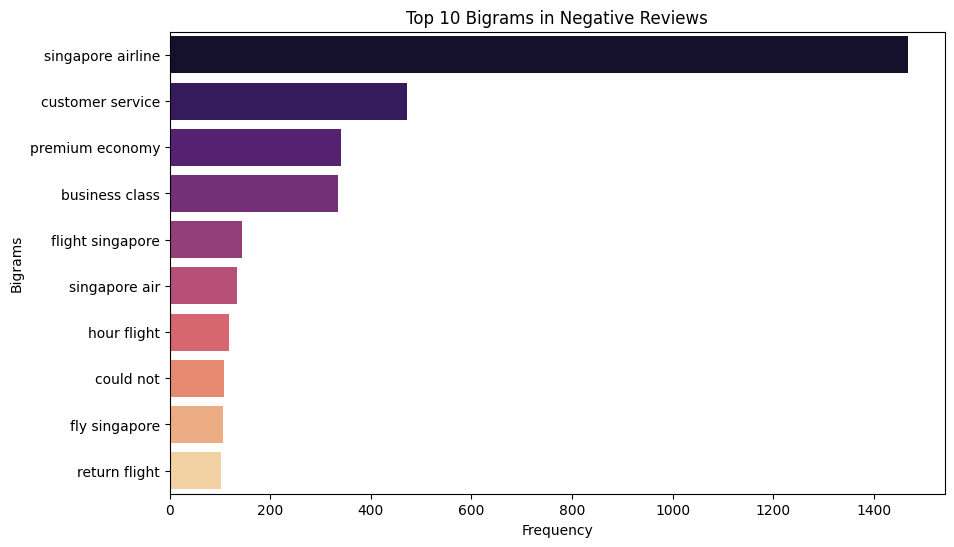

In [98]:
# Get top 10 bigrams for positive reviews
negative_bigrams = ngram_by_sentiment(data, 'Negative', n=2)
print(negative_bigrams)

# Plot bigrams in positive reviews
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='2-gram', data=negative_bigrams, palette='magma')
plt.title('Top 10 Bigrams in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

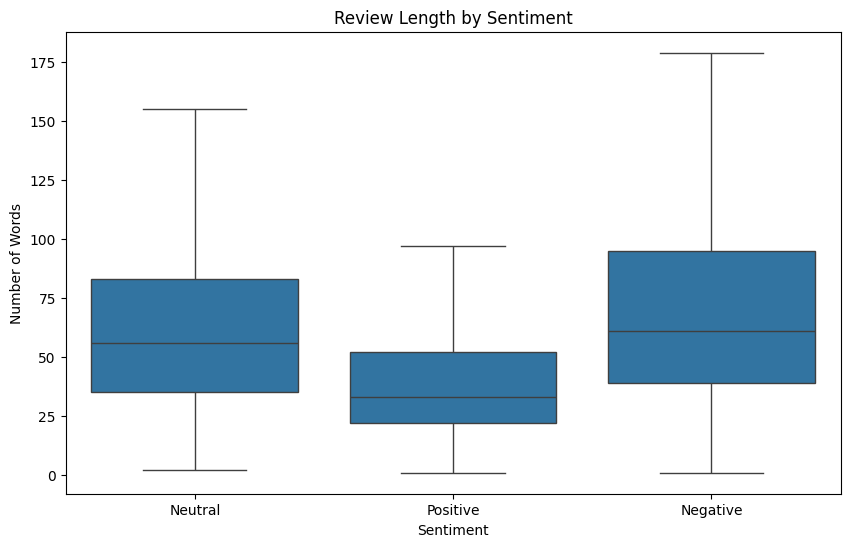

In [63]:
# Create a column for review length (assuming you have a 'full_review' or 'processed_full_review' column)
data['processed_review_length'] = data['processed_full_review'].apply(lambda x: len(x.split()))

# Plot the distribution of review length by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='processed_review_length', data=data, showfliers=False)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.show()

### Word Cloud for Each Sentiment (Positive, Neutral, Negative)

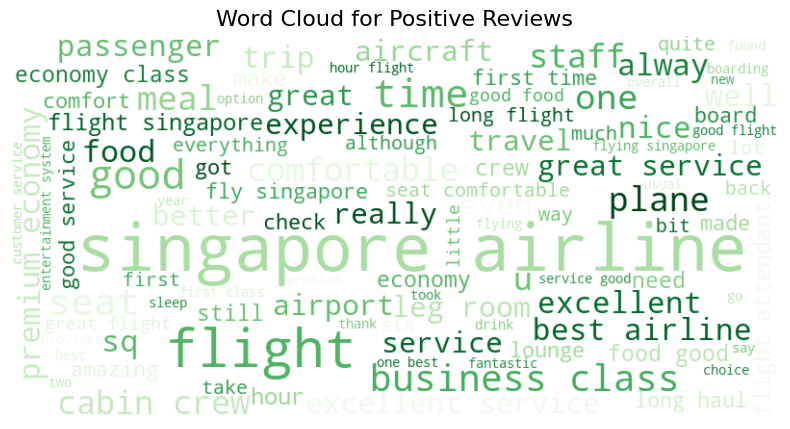

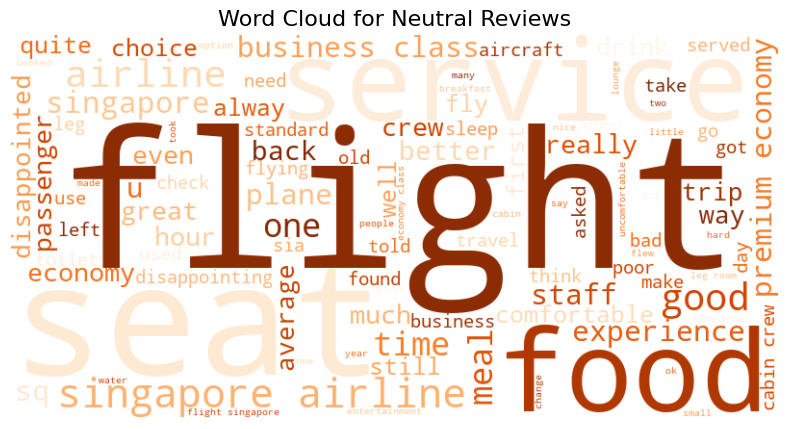

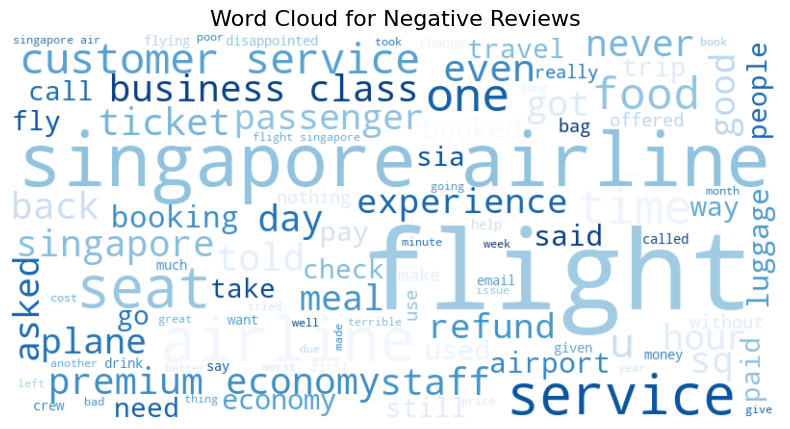

In [64]:
# Define a function to generate word clouds
def generate_wordcloud(text_data, sentiment_label, color):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color, max_words=100).generate(text_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment_label} Reviews', fontsize=16)
    plt.show()

# Filter the reviews by sentiment and join them into a single string for word cloud generation
positive_text = ' '.join(data[data['sentiment'] == 'Positive']['processed_full_review'])
neutral_text = ' '.join(data[data['sentiment'] == 'Neutral']['processed_full_review'])
negative_text = ' '.join(data[data['sentiment'] == 'Negative']['processed_full_review'])

# Generate word clouds for each sentiment
generate_wordcloud(positive_text, 'Positive', 'Greens')
generate_wordcloud(neutral_text, 'Neutral', 'Oranges')
generate_wordcloud(negative_text, 'Negative', 'Blues')


# Feature Selection
Now, we select the final features to use for our sentiment analysis of airline reviews. 
- `processed_full_review`, `rating`,`date`.

- Columns excluded: [`published_platform`,`type`,`helpful_votes`,`language`,`review_length`,`year`,`month`,`day`,`day_of_week`,`year_month`]

- Create a new DataFrame (`data_final`) by selecting the specifc columns mentioned above from the original DataFrame `data`.

In [69]:
data.head()

,published_platform,rating,type,helpful_votes,date,full_review,review_length,year,month,day,day_of_week,year_month,processed_full_review,bigrams,trigrams,sentiment,processed_review_length
0,Desktop,3,review,0,2024-03-12 18:41:14+00:00,We used this airline to go from Singapore to L...,252,2024,3,12,Tuesday,2024-03,used airline go singapore london heathrow issu...,"[used airline, airline go, go singapore, singa...","[used airline go, airline go singapore, go sin...",Neutral,132
1,Desktop,5,review,0,2024-03-11 23:39:13+00:00,The service in Suites Class makes one feel lik...,10,2024,3,11,Monday,2024-03,service suite class make one feel like vip,"[service suite, suite class, class make, make ...","[service suite class, suite class make, class ...",Positive,8
2,Desktop,1,review,0,2024-03-11 16:20:23+00:00,"Booked, paid and received email confirmation f...",83,2024,3,11,Monday,2024-03,booked paid received email confirmation extra ...,"[booked paid, paid received, received email, e...","[booked paid received, paid received email, re...",Negative,46
3,Desktop,5,review,0,2024-03-11 11:12:27+00:00,"Best airline in the world, seats, food, servic...",28,2024,3,11,Monday,2024-03,best airline world seat food service brilliant...,"[best airline, airline world, world seat, seat...","[best airline world, airline world seat, world...",Positive,17
4,Desktop,2,review,0,2024-03-10 09:34:18+00:00,Premium Economy Seating on Singapore Airlines ...,113,2024,3,10,Sunday,2024-03,premium economy seating singapore airline narr...,"[premium economy, economy seating, seating sin...","[premium economy seating, economy seating sing...",Negative,71


In [70]:
data_final = data[['processed_full_review','processed_review_length','sentiment','year','month','day_of_week']]
print(type(data_final))
data_final.head()

<class 'pandas.core.frame.DataFrame'>


,processed_full_review,processed_review_length,sentiment,year,month,day_of_week
0,used airline go singapore london heathrow issu...,132,Neutral,2024,3,Tuesday
1,service suite class make one feel like vip,8,Positive,2024,3,Monday
2,booked paid received email confirmation extra ...,46,Negative,2024,3,Monday
3,best airline world seat food service brilliant...,17,Positive,2024,3,Monday
4,premium economy seating singapore airline narr...,71,Negative,2024,3,Sunday
